In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox016.jpeg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox032.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox075.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox042.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox043.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox059.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox077.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes/fox/fox074.jpg
/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Fox

# **Import**

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

# **1. Data Import**

In [43]:
data_dir = '/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes'

In [44]:
BATCH_SIZE = 32
IMAGE_SIZE = 180
CHANNELS = 3

In [45]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 308 files belonging to 3 classes.


# **2. Data Visualization**

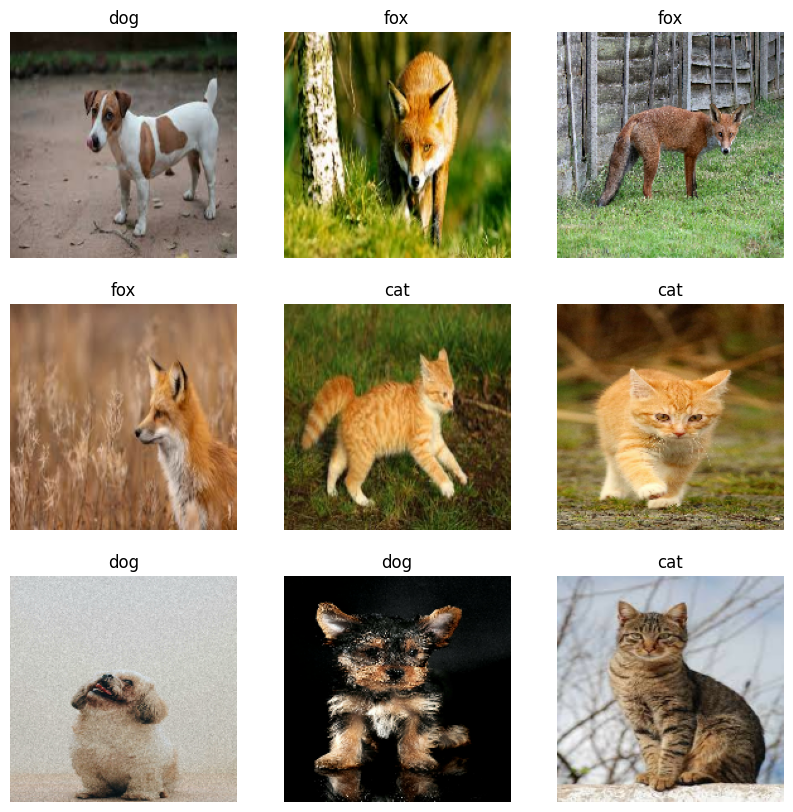

In [46]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **3. Modeling**

## **Train Test Split**

In [47]:
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2)
test_size = int(len(dataset)*.1)

In [48]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [49]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## **CNN**

In [50]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [54]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs=10
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step - accuracy: 0.9336 - loss: 0.2624 - val_accuracy: 0.8594 - val_loss: 0.4204
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.9500 - loss: 0.1836 - val_accuracy: 0.8438 - val_loss: 0.4473
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 0.9506 - loss: 0.1523 - val_accuracy: 0.8906 - val_loss: 0.3657
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.9957 - loss: 0.0803 - val_accuracy: 0.8906 - val_loss: 0.3948
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step - accuracy: 0.9915 - loss: 0.0501 - val_accuracy: 0.8594 - val_loss: 0.4936
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 1.0000 - loss: 0.0436 - val_accuracy: 0.8594 - val_loss: 0.4735
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 0.8750 - val_loss: 0.4125
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.8750 - val_loss:

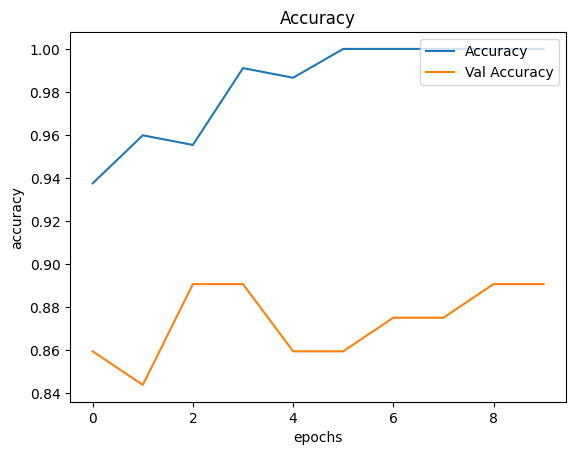

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

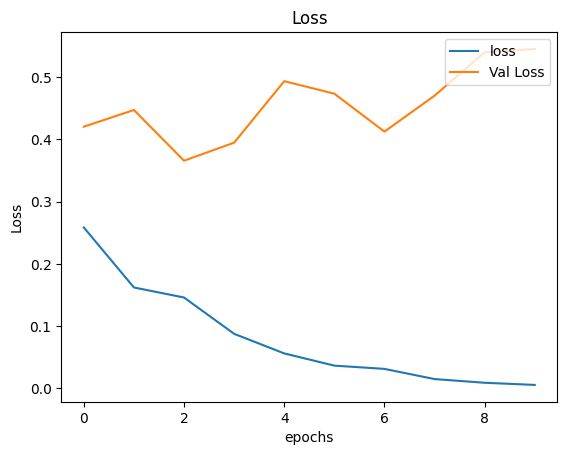

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

first image to predict
actual label: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
predicted label: dog


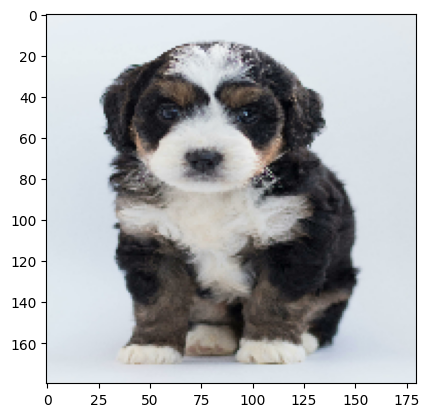

In [65]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.show()

## **Prediction**

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


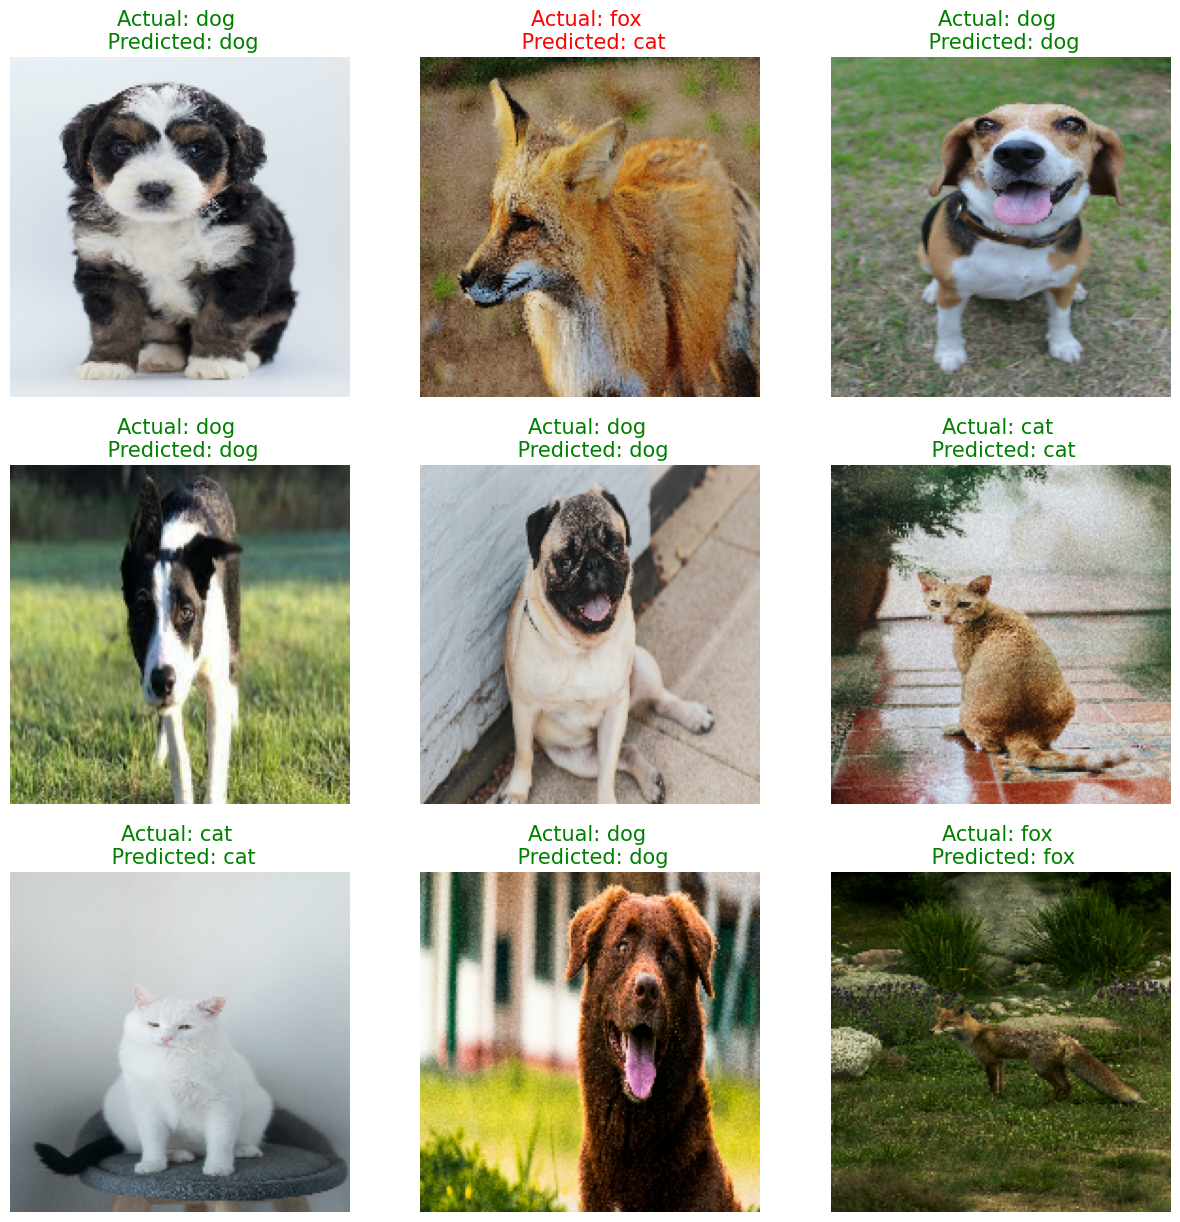

In [77]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        if actual_class == predicted_class:
            label_color = 'green'
        else:
            label_color = 'red'
            
        plt.title(f'Actual: {actual_class} \n Predicted: {predicted_class}', color=label_color, fontsize=15)

        plt.axis("off")

------------

**Please leave your advice in the comments. Thank you**